# Implementing  BVEP brain network model in PyMc3


In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import json
import pickle

# from scipy.optimize import fsolve
# from scipy.optimize import root

import scikitplot as skplt
from sklearn.metrics import confusion_matrix

# from pandas.plotting import scatter_matrix
# from pandas_ml import ConfusionMatrix


# import re
# import glob
# from itertools import chain
# from operator import itemgetter

In [5]:
import pymc3 as pm
import theano
import theano.tensor as tt

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [8]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.4
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [9]:
%pylab inline
#%matplotlib inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [10]:
from report_nodetype import node_EzPzHz_idex
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage
from report_nodetype import node_score_std_extrm, node_score_ezpz

# Syntetic Data

In [11]:
data_dir = 'data_input_files'
results_dir = 'data_output_files'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

In [12]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /data/meysam/VepSyntheticData/BVEP_Benchmarking/BVEP_PyMc3


In [13]:
Mainpath =cwd+"/"

In [14]:
Reportmetrics_dir = os.path.join(cwd, Mainpath+"/data_output_files/figures/")

In [15]:
eta_true_inx, eta_true_mu, eta_true_sd = np.loadtxt(Mainpath+"ExperimentalData_CJ"+"/"+"eta_patient1"+".txt", delimiter=',', usecols=(0,1,2), skiprows=1, ).T 

In [16]:
with open(Mainpath+"ExperimentalData_CJ"+"/"+"true_labels_nodes_patient1"+".txt", 'r') as filehandle:  
          true_labels_nodes = json.load(filehandle)              

In [17]:
data_input = np.load(Mainpath+"data_input_files/"+"DatainputSLRawDecim84nodes_patient1.npz")

In [18]:
Obs = data_input['Obs']
#Obs2 = data_input['Obs2']
SC = data_input['SC']
tau0 = data_input['tau0']
Ks = data_input['Ks']
nodes=data_input['nodes']
num_nodes=data_input['nn']
ts = data_input['ts']

In [19]:
Obs.shape

(120, 84)

In [20]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

In [21]:
eta_ez= -1.6
eta_pz= -2.4
eta_hz= -3.65

In [22]:
Ez_indices, Pz_indices, Hz_indices, Ez_arr, Pz_arr, Hz_arr= node_EzPzHz_idex(true_labels_nodes)

In [23]:
print("Ez_indices:", Ez_indices)
print("Pz_indices:", Pz_indices)

Ez_indices: [6, 34]
Pz_indices: [5, 11, 27]


# Provisioning BVEP

## Observation

In [24]:
network = np.load(f'{data_dir}/DatainputSLRawDecim84nodes_patient1.R.npz')

In [25]:
xs = np.load(f'{data_dir}/DatainputSLRawDecim84nodes_patient1.R.npz')['Obs']

In [26]:
xs.shape

(120, 84)

In [27]:
obs = dict()
obs['xs'] = xs

In [28]:
xs_pwr = (xs*xs).sum (axis=0)
xs_pwr = (xs_pwr/ xs_pwr.max())

In [29]:
obs['xs_pwr']=xs_pwr

In [30]:
eni_idx=np.argsort(obs['xs_pwr'])
eni_idx

array([ 6, 34, 27, 11,  5, 83,  9,  7, 29, 60, 20, 14, 13, 23, 16, 28, 54,
        3,  4, 19, 61, 39,  0, 78, 81, 72, 22, 57, 58, 38, 42, 52, 41, 36,
        1, 35, 76, 46, 80, 65, 53, 26, 51, 62, 12,  8, 10, 43, 47, 21, 45,
       66, 82, 33,  2, 75, 59, 79, 73, 68, 44, 69, 50, 17, 15, 32, 64, 55,
       71, 67, 40, 18, 25, 63, 24, 56, 70, 77, 37, 30, 31, 74, 48, 49])

In [31]:
obs['xs'].shape

(120, 84)

## constants

In [33]:
consts = dict()
consts['nn'] = network['nn']
consts['nt'] = network['nt']
consts['SC'] = network['SC']
consts['I1'] = network['I1']
consts['tau0'] = network['tau0']
consts['time_step'] = 0.1

## Prior

In [34]:
prior_mu = dict()
prior_mu['eta'] = -2.5
prior_mu['amplitude'] = 1.0
prior_mu['offset'] = 0.0
prior_mu['K'] = 1.0
prior_mu['tau0'] = 10.0
prior_mu['x_init'] = -1.5
prior_mu['z_init'] = +3.5 

## Generative Model

In [35]:
from BVEP_PyMC3 import BVEP_noncen

Lets run Nuts with defalut initiation, but the same as we ran Stan:
* warmup: 1000 
* samoling: 250
* target_accept: 0.95
* max_treedepth: 10.

In [36]:
BVEP_sde_noncen = BVEP_noncen(consts=consts, prior_mu=prior_mu, obs=obs)

In [37]:
NUTS_KWARGS={'target_accept':0.95, 'max_treedepth': 10.}
nuts_kwargs = dict(target_accept=.95)

In [38]:
from pymc3.backends import SQLite
from pymc3.backends import Text

In [352]:
with BVEP_sde_noncen.model:
    step=pm.NUTS()
    trace_nuts = pm.sample(draws=250, tune=1000, nuts_kwargs=dict(target_accept=0.95),  model=BVEP_sde_noncen.model)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [z_eta, x_eta, z_init_star, x_init_star, dtt, sig, eps, K_star, offset_star, amplitude_star, x0_star]
Sampling 4 chains: 100%|██████████| 5000/5000 [31:31:49<00:00,  4.98s/draws]     
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [92]:
chn_idx=0

In [93]:
x_nuts=np.asarray(trace_nuts.get_values('x', burn=0, combine=False))[chn_idx,:,:,:]
z_nuts=np.asarray(trace_nuts.get_values('z', burn=0, combine=False))[chn_idx,:,:,:]

x_nuts.shape, z_nuts.shape

((250, 120, 84), (250, 120, 84))

In [94]:
eta_est_nuts=np.asarray(trace_nuts.get_values('eta', burn=0, combine=False))[chn_idx,:,:]
Kest_nuts=np.asarray(trace_nuts.get_values('K', burn=0, combine=False))[chn_idx,:]
amplitude_nuts=np.asarray(trace_nuts.get_values('amplitude', burn=0, combine=False))[chn_idx,:]
offset_nuts=np.asarray(trace_nuts.get_values('offset', burn=0, combine=False))[chn_idx,:]
eps_nuts=np.asarray(trace_nuts.get_values('eps', burn=0, combine=False))[chn_idx,:]
sig_nuts=np.asarray(trace_nuts.get_values('sig', burn=0, combine=False))[chn_idx,:]

In [95]:
eta_est_nuts.shape, amplitude_nuts.shape, Kest_nuts.shape, sig_nuts.shape

((250, 84), (250,), (250,), (250,))

In [96]:
x_est_nuts, z_est_nuts, amplitude_est_nuts, offset_est_nuts = np.transpose(x_nuts, (0, 2, 1)),  np.transpose(z_nuts, (0, 2, 1)), amplitude_nuts.reshape((-1, 1, 1)),  offset_nuts.reshape((-1, 1, 1))
x_est_nuts.shape, amplitude_est_nuts.shape

((250, 84, 120), (250, 1, 1))

In [97]:
Obs_est_nuts =  amplitude_est_nuts*x_est_nuts + offset_est_nuts
Obs_est_nuts.shape

(250, 84, 120)

In [98]:
eta_est_mu_nuts=np.mean(eta_est_nuts, axis=0)
eta_est_std_nuts=np.std(eta_est_nuts, axis=0)

In [99]:
Obs_low_nuts, Obs_hi_nuts = percentile(Obs_est_nuts, [5, 95], axis=0)
LSE_val_nuts=LSE_obs(Obs.T, Obs_low_nuts, Obs_hi_nuts)
print('LSE_val_nuts=', LSE_val_nuts)

LSE_val_nuts= 57.4203659212


In [100]:
err_eta_nuts=Err(eta_true_mu, eta_est_mu_nuts)
z_score_eta_nuts=np.sum(z_score(eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts))
shrinkage_eta_nuts=np.mean(shrinkage([prior_std]*nodes.shape[0], eta_est_std_nuts))

In [101]:
score_std_nuts, score_extrm_nuts= node_score_std_extrm(nodes, eta_est_nuts, eta_true_mu, sd_thr)
score_ez_nuts, score_pz_nuts, ce_nuts, cp_nuts, nodes_est_nuts, est_labels_nodes_nuts= node_score_ezpz(nodes, x0est_nuts, true_labels_nodes, eta_c, delta_eta, 1.)
print ('Prediction about Ez and Pz nodes is=', int(score_ez_nuts+score_pz_nuts),' out of', len(Ez_indices)+len(Pz_indices), ' EzPznodes')                                              

Prediction about Ez and Pz nodes is= 5  out of 5  EzPznodes


In [102]:
y_true=true_labels_nodes
y_pred_nuts=est_labels_nodes_nuts                                           
confusion_matrix_values_nuts= confusion_matrix(y_true, y_pred_nuts, labels=["EZ", "PZ", "HZ"])
accuracy_nuts=100*np.trace(confusion_matrix_values_nuts)/np.sum(confusion_matrix_values_nuts)
print ('Prediction about all the node types is=', int(np.trace(confusion_matrix_values_nuts)),' out of', len(nodes), ' nodes')

Prediction about all the node types is= 84  out of 84  nodes


In [103]:
showpicks = f_vector_int(np.r_[int(Hz_indices[0]), int(Pz_indices[0]), int(Ez_indices[0])])
showpicks=showpicks.tolist()
print("Shown nodes are:", [(x+1) for x in showpicks])

Shown nodes are: [1, 6, 7]


In [104]:
Obs.shape, Obs_est_nuts.shape, Obs_low_nuts.shape

((120, 84), (250, 84, 120), (84, 120))

In [105]:
from report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

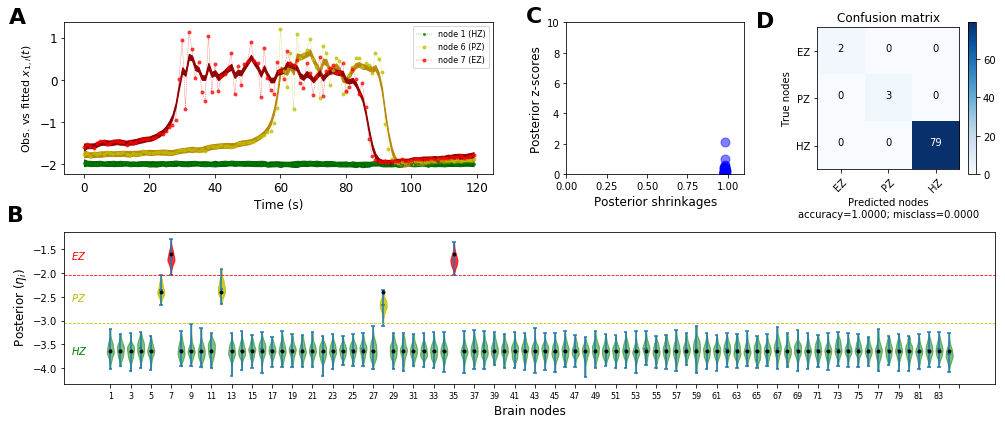

In [106]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(0.1*ts, Obs, np.transpose(Obs_est_nuts, (0, 2, 1)), showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values_nuts, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), x0est_nuts)
plt.savefig(os.path.join(Reportmetrics_dir, 'figure-fit_nuts_BVEP3_noncentered_DatainputSLRawDecim84nodes_patient1_ch0'+'.png'), dpi=300) 
plt.show()

## combined chains

In [326]:
x_nuts=np.asarray(trace_nuts.get_values('x', burn=0, combine=True))
z_nuts=np.asarray(trace_nuts.get_values('z', burn=0, combine=True))

x_nuts.shape, z_nuts.shape

((1000, 120, 84), (1000, 120, 84))

In [327]:
eta_est_nuts=np.asarray(trace_nuts.get_values('eta', burn=0, combine=True))
Kest_nuts=np.asarray(trace_nuts.get_values('K', burn=0, combine=True))
amplitude_nuts=np.asarray(trace_nuts.get_values('amplitude', burn=0, combine=True))
offset_nuts=np.asarray(trace_nuts.get_values('offset', burn=0, combine=True))
eps_nuts=np.asarray(trace_nuts.get_values('eps', burn=0, combine=True))
sig_nuts=np.asarray(trace_nuts.get_values('sig', burn=0, combine=True))

In [328]:
eta_est_nuts.shape, amplitude_nuts.shape, Kest_nuts.shape, sig_nuts.shape

((1000, 84), (1000,), (1000,), (1000,))

In [329]:
x_est_nuts, z_est_nuts, amplitude_est_nuts, offset_est_nuts = np.transpose(x_nuts, (0, 2, 1)),  np.transpose(z_nuts, (0, 2, 1)), amplitude_nuts.reshape((-1, 1, 1)),  offset_nuts.reshape((-1, 1, 1))
x_est_nuts.shape, amplitude_est_nuts.shape

((1000, 84, 120), (1000, 1, 1))

In [330]:
Obs_est_nuts =  amplitude_est_nuts*x_est_nuts + offset_est_nuts
Obs_est_nuts.shape

(1000, 84, 120)

In [331]:
eta_est_mu_nuts=np.mean(eta_est_nuts, axis=0)
eta_est_std_nuts=np.std(eta_est_nuts, axis=0)

In [332]:
Obs_low_nuts, Obs_hi_nuts = percentile(Obs_est_nuts, [5, 95], axis=0)
LSE_val_nuts=LSE_obs(Obs.T, Obs_low_nuts, Obs_hi_nuts)
print('LSE_val_nuts=', LSE_val_nuts)

LSE_val_nuts= 58.04987926054484


In [333]:
err_eta_nuts=Err(eta_true_mu, eta_est_mu_nuts)
z_score_eta_nuts=np.sum(z_score(eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts))
shrinkage_eta_nuts=np.mean(shrinkage([prior_std]*nodes.shape[0], eta_est_std_nuts))

In [334]:
score_std_nuts, score_extrm_nuts= node_score_std_extrm(nodes, eta_est_nuts, eta_true_mu, sd_thr)
score_ez_nuts, score_pz_nuts, ce_nuts, cp_nuts, nodes_est_nuts, est_labels_nodes_nuts= node_score_ezpz(nodes, eta_est_nuts, true_labels_nodes, eta_c, delta_eta, 1.)
print ('Prediction about Ez and Pz nodes is=', int(score_ez_nuts+score_pz_nuts),' out of', len(Ez_indices)+len(Pz_indices), ' EzPznodes')                                              

Prediction about Ez and Pz nodes is= 5  out of 5  EzPznodes


In [335]:
y_true=true_labels_nodes
y_pred_nuts=est_labels_nodes_nuts                                           
confusion_matrix_values_nuts= confusion_matrix(y_true, y_pred_nuts, labels=["EZ", "PZ", "HZ"])
accuracy_nuts=100*np.trace(confusion_matrix_values_nuts)/np.sum(confusion_matrix_values_nuts)
print ('Prediction about all the node types is=', int(np.trace(confusion_matrix_values_nuts)),' out of', len(nodes), ' nodes')

Prediction about all the node types is= 84  out of 84  nodes


In [336]:
showpicks = f_vector_int(np.r_[int(Hz_indices[0]), int(Pz_indices[0]), int(Ez_indices[0])])
showpicks=showpicks.tolist()
print("Shown nodes are:", [(x+1) for x in showpicks])

Shown nodes are: [1, 6, 7]


In [337]:
Obs.shape, Obs_est_nuts.shape, Obs_low_nuts.shape

((120, 84), (1000, 84, 120), (84, 120))

In [338]:
from report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

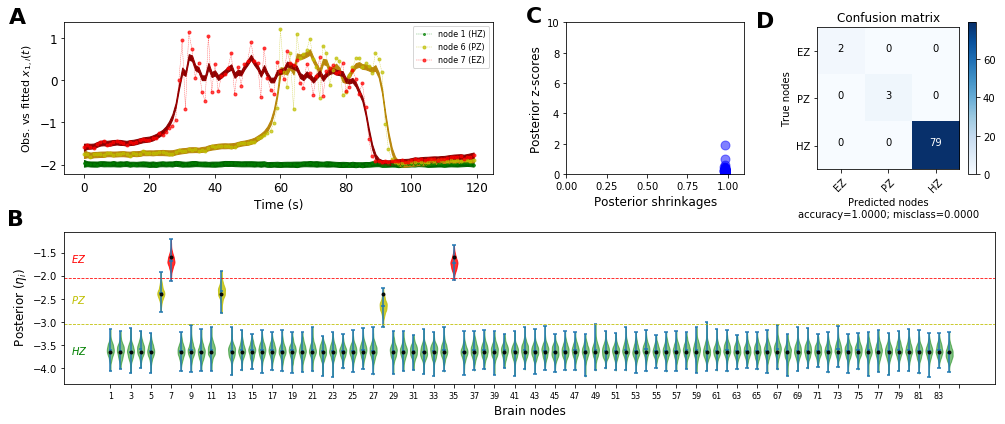

In [339]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(0.1*ts, Obs, np.transpose(Obs_est_nuts, (0, 2, 1)), showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, eta_true_mu, eta_est_mu_nuts, eta_est_std_nuts, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values_nuts, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), x0est_nuts)
plt.savefig(os.path.join(Reportmetrics_dir, 'figure-fit_nuts_BVEP3_noncentered_DatainputSLRawDecim84nodes_patient1_4chains'+'.png'), dpi=300) 
plt.show()

In [508]:
def plot_posterior(nodes ,x0c, deltax0, x0hz, x0ez, x0pz, Hz_idx, Ez_idx, Pz_idx, x0est): 
        parts= plt.violinplot(x0est, widths=0.7, showmeans=True, showextrema=True);
        plt.plot(Ez_idx+1, x0ez*ones((len(Ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
        plt.plot(Pz_idx+1, x0pz*ones((len(Pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
        plt.plot(Hz_idx+1, x0hz*ones((len(Hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
        plt.axhline(y=x0c, linewidth=.8, color = 'r', linestyle='--')
        plt.axhline(y=x0c-deltax0, linewidth=.8, color = 'y', linestyle='--')
        text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
        text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
        text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
        #plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
        plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
        plt.yticks(np.arange(-4, -1, 1),np.arange(-4, -1, 1), fontsize=12)

        plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
        plt.xlabel('Brain nodes', fontsize=14); 
        plt.tight_layout()
        plt.text(-9.2, -.9, "B" ,fontsize=24, fontweight='bold')

        for pc in parts['bodies'][0:nodes.shape[0]]:
            pc.set_facecolor('g')
            pc.set_edgecolor('g')
            pc.set_alpha(0.5)
        i = 0
        while i < len(Ez_idx):
            for pc in parts['bodies'][Ez_idx[i]:Ez_idx[i]+1]:
                pc.set_facecolor('r')
                pc.set_edgecolor('r')
                pc.set_alpha(0.8)
            i += 1

        j = 0
        while j < len(Pz_idx):
            for pc in parts['bodies'][Pz_idx[j]:Pz_idx[j]+1]:
                pc.set_facecolor('y')
                pc.set_edgecolor('y')
                pc.set_alpha(0.8)
            j += 1

In [509]:
def plot_features(ts, Obs, Obs_est, showpicks):
       Obs_lo, Obs_hi = percentile(Obs_est, [5, 95], axis=0)
       t_Obs = np.r_[:Obs_lo.shape[0]]
       plt.fill_between(ts, Obs_lo[:, showpicks[0]], Obs_hi[:, showpicks[0]], color='green', alpha=.6, zorder=8) 
       plt.fill_between(ts, Obs_lo[:, showpicks[1]], Obs_hi[:, showpicks[1]], color='darkgoldenrod', alpha=.9, zorder=8) 
       plt.fill_between(ts, Obs_lo[:, showpicks[2]], Obs_hi[:, showpicks[2]], color='darkred', alpha=.5, zorder=8) 

       plt.plot(ts, Obs[:, showpicks[0]], color='g',alpha=.4, linestyle='--', marker= '.' , markersize=14, linewidth=1, label=f'node {showpicks[0]+1} (HZ)', zorder=4)
       plt.plot(ts, Obs[:, showpicks[1]], color='y',alpha=.7,  linestyle='--', marker= '.' , markersize=14, linewidth=1, label=f'node {showpicks[1]+1} (PZ)', zorder=4)
       plt.plot(ts, Obs[:, showpicks[2]], color='red', alpha=.8, linestyle='--', marker= '.' , markersize=14, linewidth=1, label=f'node {showpicks[2]+1} (EZ)', zorder=4)
     
       #for i, (pl_lo, pl_hi) in enumerate(zip(Obs_lo.T, Obs_hi.T)):
       #     if i in showpicks:
            # plt.fill_between(ts, pl_lo, pl_hi, alpha=0.95, linewidth=12.0)               
       # leg = []     
       # for i in  showpicks :
       #      leg.append(f'node {i+1}')
       # plt.legend(leg)
        
       plt.legend(fontsize=9)
       plt.ylabel('Obs. vs fitted '+r'$ x_{1,i}(t)$', fontsize=14);        
       plt.xlabel('Time (s)', fontsize=14); 
       plt.xticks(fontsize=14)
       plt.yticks(fontsize=14)
       plt.text(-23.0, 1.5, "A" ,fontsize=24, fontweight='bold')

In [510]:
def plot_zscore_shrinkage(nodes, x0true_mu, x0est_mu, x0est_std, prior_std):
    z_score_x0=z_score(x0true_mu, x0est_mu, x0est_std)
    colors= np.random.rand(z_score_x0.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], x0est_std), z_score_x0 ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=14)
    plt.ylabel("Posterior z-scores", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis((0,1.1,0,10))
    plt.text(-.4, 10.4, "C" ,fontsize=24, fontweight='bold')

In [507]:
def plot_confusion_matrix(cm, target_names,  cmap=None, normalize=False):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names, rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.title('Confusion matrix', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('True nodes', fontsize=12)
    plt.xlabel('Predicted nodes\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=12)
    plt.text(-1.8, -.6, "D" ,fontsize=24, fontweight='bold')


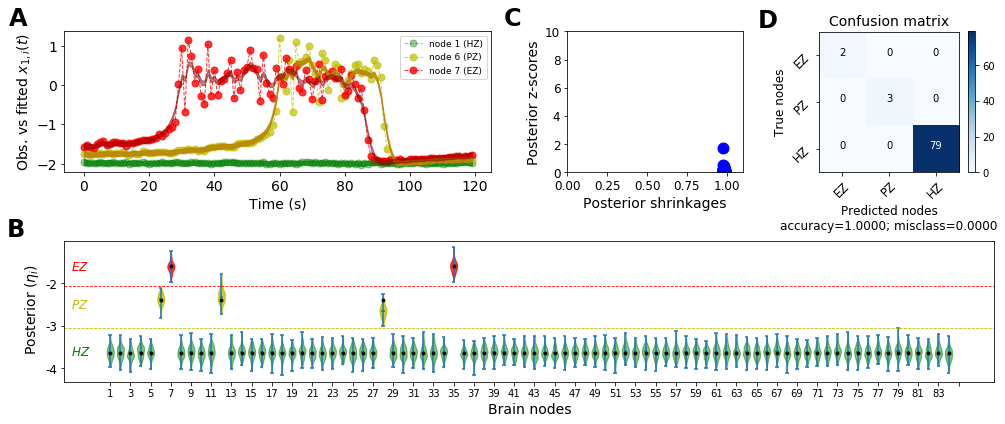

In [511]:
plt.figure(figsize=(14, 6))  
grid = plt.GridSpec(2, 4)  
plt.subplot(grid[0, :2]) 
plot_features(0.1*ts, Obs, np.transpose(Obs_est_nuts, (0, 2, 1)), showpicks)
plt.subplot(grid[0, 2]) 
plot_zscore_shrinkage(nodes, x0true_mu, x0est_mu_nuts, x0est_std_nuts, prior_std)
plt.subplot(grid[0, 3]) 
plot_confusion_matrix(confusion_matrix_values_nuts, ["EZ", "PZ", "HZ"])
plt.subplot(grid[1, 0:])            
plot_posterior(nodes, x0c, deltax0, x0hz, x0ez, x0pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), x0est_nuts)
plt.savefig(os.path.join(Reportmetrics_dir, 'figure-fit_nuts_BVEP3_noncentered_DatainputSLRawDecim84nodes_patient1'+'.png'), dpi=300) 
plt.savefig(os.path.join(Reportmetrics_dir, 'Fig3_pymc3_patient1'+'.png'), dpi=600) 
plt.savefig(os.path.join(Reportmetrics_dir, 'Fig3_pymc3_patient1'+'.eps'), dpi=600) 
plt.show()

# \Rhat

In [377]:
R_hat=pm.diagnostics.gelman_rubin(trace_nuts)

In [380]:
r_hats = np.array([])
for key in R_hat.keys():
    r_hats = np.concatenate((r_hats, np.array([R_hat[key]]) if type(R_hat[key]) is np.float64 else R_hat[key].flatten()))

In [381]:
r_hats.shape

(50913,)

plot rhat done!


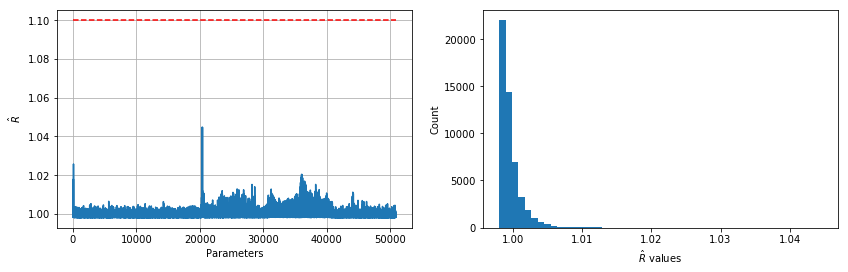

In [382]:
plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.plot(r_hats)
plt.hlines(y=1.1, xmin=0., xmax=r_hats.shape[0], linewidth=1.5, color = 'red', linestyle='--', zorder=5)
#plt.text(-1, 1.1, "$\hat R=1.1$", size=8, color = 'y', zorder=3)
#plt.text(-1, 1.4,  r'$\hat R > 1.1:\ \ $'+str(Rhat_large)+r'$/$' + str( len(rhats[names.index])) , size=8, color = 'red', zorder=4)
#plt.text(-1, 1.4,  r'$\hat R > 1.1:\ \ $'+str(Rhat_large_percent)+r'$\%$' , size=8, color = 'red', zorder=4)
plt.grid()
plt.xlabel('Parameters')
plt.ylabel(r'$\hat R$')
plt.subplot(1, 2, 2)
plt.hist(r_hats, bins=50)
plt.xlabel(r'$\hat R$ values')
plt.ylabel('Count')
print('plot rhat done!')
plt.savefig(os.path.join(Reportmetrics_dir, 'figure_Rhat_nuts_BVEP3_noncentered_DatainputSLRawDecim84nodes_patient1'+'.png'), dpi=300) 


In [383]:
Rhat_keys = [] 
#Rhat_values =[] 
for key in R_hat.keys():
    Rhat_keys.append(key)
    #Rhat_values.append(np.asarray(R_hat_truncated_dtt[key])[newaxis])

In [385]:
fit_summary=pm.stats.summary(trace_nuts)

In [386]:
Rhat_values = fit_summary['Rhat']
rhats=pd.to_numeric(Rhat_values, errors='coerce')

In [387]:
fit_summary.to_csv(directory_nuts_noncentered+"/"+ 'fit_summary_nuts_BVEP3_noncentered_DatainputSLRawDecim84nodes_patinet1.csv')

In [388]:
names = fit_summary.index
names

Index(['x0_star__0', 'x0_star__1', 'x0_star__2', 'x0_star__3', 'x0_star__4',
       'x0_star__5', 'x0_star__6', 'x0_star__7', 'x0_star__8', 'x0_star__9',
       ...
       'xhat__119_74', 'xhat__119_75', 'xhat__119_76', 'xhat__119_77',
       'xhat__119_78', 'xhat__119_79', 'xhat__119_80', 'xhat__119_81',
       'xhat__119_82', 'xhat__119_83'],
      dtype='object', length=50913)

In [389]:
def check_rhat(fit_summary):
    """Checks the potential scale reduction factors"""
    from math import isnan
    from math import isinf

    Rhat_values = fit_summary['Rhat']
    rhats=pd.to_numeric(Rhat_values, errors='coerce')
    rhats = rhats[~np.isnan(rhats)]   
    names = fit_summary.index
    prefixes = ["xhat"]
    names= names[~names.str.startswith(tuple(prefixes))]
    no_warning = True
    i=0
    j=0
    for rhat, name in zip(rhats, names):
        j=j+1 
        if (rhat > 1.1):
            print('Rhat for parameter {} is {}'.format(name, rhat))
            i=i+1
            no_warning = False
    print('Rhat >1.1: {} out of {} parameters' .format(i, j))
    if no_warning:
        print('Rhat looks reasonable for all parameters')
    else:
        print('  Rhat above 1.1 indicates that the chains very likely have not mixed')

In [390]:
check_rhat(fit_summary)

Rhat >1.1: 0 out of 40833 parameters
Rhat looks reasonable for all parameters
